In [1]:
import torch
import numpy as np

import eznf
from eznf import datasets

In [2]:
a = torch.Tensor(1,3)
mst = datasets.MNIST('./', True)
X_train, Y_train, X_test, Ytest = mst.get()

label:0


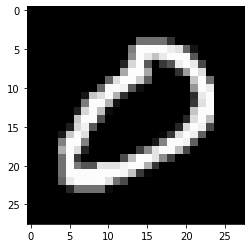

In [3]:
mst.show_one_sample()

In [6]:
class Tensor:
    def __init__(self, *args, device=None):
        if(isinstance(args[0], list) or isinstance(args[0], np.ndarray)):
            self.item = np.array(args[0], float)
        else:
            self.item = np.random.random(args)

        self.device = device


    def __str__(self):
        return 'tensor({})'.format(self.item)
    
    def __sum__(self):
        print('aa')

In [8]:
b = Tensor(1,1)


TypeError: unsupported operand type(s) for +: 'int' and 'Tensor'

In [12]:
import numpy as np

people = np.array(['李浩宇', '陈腾', '刘天一', '秦臻远'])

class MLP(torch.nn.Module):
    def __init__(self):
        self.l1 = torch.nn.Linear(8, 64)
        self.l2 = torch.nn.Linear(64, 512)


    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

array(['刘天一'], dtype='<U3')